<a href="https://colab.research.google.com/github/noorulghousiah/MFCC-and-Neural-Network-Based-Recognition-of-Spoken-Words/blob/main/DL_AudioClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


MCTA 4363: Deep Learning

Assignment 1 -  Single-Word Audio Classification

Name: **NOORUL GHOUSIAH BINTI NOORDEEN SAHIB**   Matric No: **2118298**

**Objective: Build a Neural Network to classify three spoken words from audio recordings.**

#### **Google Drive link to audio dataset**

https://drive.google.com/drive/folders/1K3FJAIn55nemVBzV6O-TCCpeZ2v9Q-5U?usp=sharing

#### **Short notes on MFCC**

**Short Notes**

MFCC stands for Mel-Frequency Cepstral Coefficients. It’s a way of turning sound (like your audio files) into numbers


So we use MFCC to extract meaningful features from the audio. These features represent:
The pitch, The tone, The timbre (character of sound)

MFCC compresses this info into a compact set of values (usually 13–40 coefficients) that capture the essence of how a word sounds — kind of like a "fingerprint" for each word.

## **Get Audio and Preprocessing Steps**

In [ ]:
import os
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import torchaudio.transforms as T

import matplotlib.pyplot as plt
import torch


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

data_path = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/AUDIO_DATA/AUDIO_CLASSIFICATION'


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Define MFCC transformation
mfcc_transform = T.MFCC(
    sample_rate=16000,
    n_mfcc=13,
    melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23}
)


# Custom Dataset Class
class AudioDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Assume folder names are word labels
        for label, word in enumerate(sorted(os.listdir(root_dir))):
            word_path = os.path.join(root_dir, word)
            for file in os.listdir(word_path):
                if file.endswith(".wav"):
                    self.samples.append((os.path.join(word_path, file), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        filepath, label = self.samples[idx]
        waveform, sr = torchaudio.load(filepath)

        # Convert to mono (averaging channels)
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)

        # Resample if needed
        if sr != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
            waveform = resampler(waveform)

        # Apply MFCC
        mfcc = self.transform(waveform)

        # Normalize MFCC
        mean = mfcc.mean(dim=-1, keepdim=True)
        std = mfcc.std(dim=-1, keepdim=True)
        mfcc = (mfcc - mean) / (std + 1e-5)  # Add small value to avoid divide by zero

        mean = mfcc.mean()
        std = mfcc.std()

        # Pad or truncate to fixed length = 200
        max_len = 200
        if mfcc.shape[-1] < max_len:
            pad_amt = max_len - mfcc.shape[-1]
            mfcc = torch.nn.functional.pad(mfcc, (0, pad_amt))  # pad at end
        else:
            mfcc = mfcc[:, :, :max_len]  # cut off extra time steps

        return mfcc, label


# Define get_dataloader function
def get_dataloader(batch_size=4, num_workers=0, root_dir=data_path):
    train_dataset = AudioDataset(root_dir=os.path.join(root_dir, "TRAINING_DATASET"), transform=mfcc_transform)
    test_dataset = AudioDataset(root_dir=os.path.join(root_dir, "TESTING_DATASET"), transform=mfcc_transform)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=num_workers)

    return train_dataloader, test_dataloader, train_dataset, test_dataset



In [ ]:
train_loader, test_loader , train_dataset, test_dataset = get_dataloader(batch_size=4, num_workers=0)


class_names = ('subhanallah', 'allahuakbar', 'alhamdulillah')

**The dataset is split manually.
 80% training, 20% testing, in which 2 person for testing and 8 person for training.**

##**CHECK**

In [ ]:
def dataset_statistics(dataset):
    all_mfcc = []

    for i in range(len(dataset)):
        mfcc, _ = dataset[i]
        all_mfcc.append(mfcc)

    all_mfcc = torch.stack(all_mfcc)  # shape: [N, 1, 13, 200]

    stats = {
        "Total samples": len(dataset),
        "Shape of each sample": all_mfcc[0].shape,
        "Global Min": torch.min(all_mfcc).item(),
        "Global Max": torch.max(all_mfcc).item(),
        "Mean": torch.mean(all_mfcc).item(),
        "Std Dev": torch.std(all_mfcc).item(),
    }

    for k, v in stats.items():
        print(f"{k}: {v}")

print("📊 Training Set Statistics")
dataset_statistics(train_loader.dataset)

print("\n📊 Test Set Statistics")
dataset_statistics(test_loader.dataset)

for batch_mfcc, batch_labels in train_loader:
    print("Batch MFCC shape:", batch_mfcc.shape)
    print("Batch labels:", batch_labels)
    break  # only show first batch


📊 Training Set Statistics
Total samples: 72
Shape of each sample: torch.Size([1, 13, 200])
Global Min: -4.881167888641357
Global Max: 4.447146415710449
Mean: 9.774308273335919e-05
Std Dev: 0.9043093919754028

📊 Test Set Statistics
Total samples: 18
Shape of each sample: torch.Size([1, 13, 200])
Global Min: -4.014256954193115
Global Max: 3.8537187576293945
Mean: -0.0004271347133908421
Std Dev: 0.9070203304290771
Batch MFCC shape: torch.Size([4, 1, 13, 200])
Batch labels: tensor([0, 2, 2, 1])


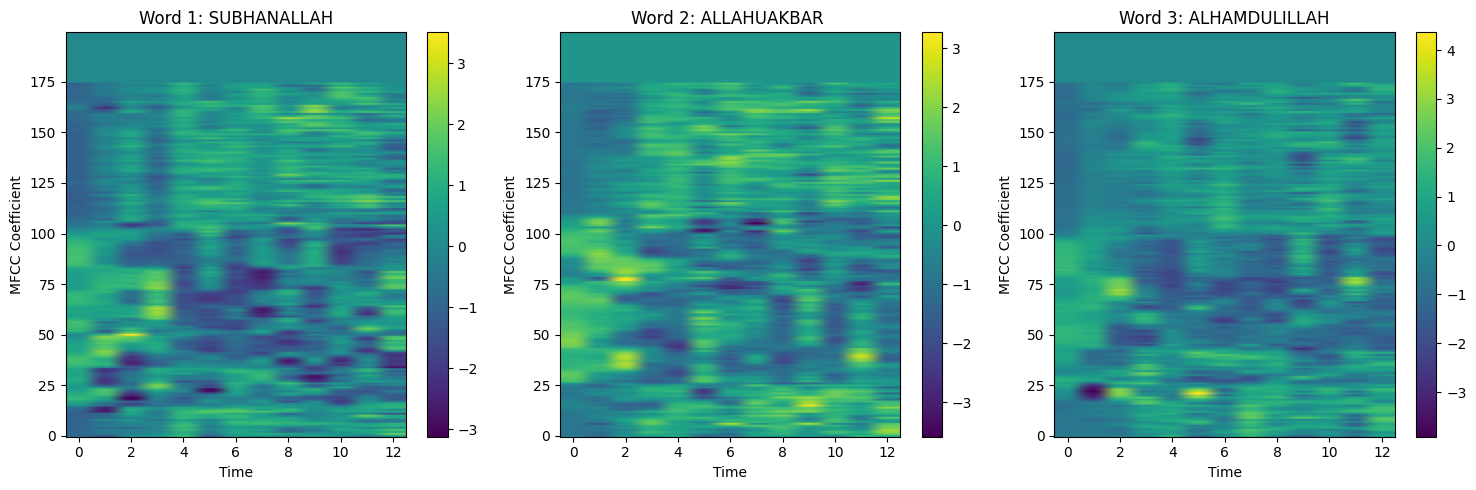

In [ ]:
# Automatically pick one sample per class
samples_by_class = {}
for i in range(len(train_dataset)):
    _, label = train_dataset[i]
    if label not in samples_by_class:
        samples_by_class[label] = train_dataset[i][0].squeeze(0).T
    if len(samples_by_class) == len(class_names):
        break

# Then use:
sample_1 = samples_by_class[0]  # SUBHANALLAH
sample_2 = samples_by_class[1]  # SALLAHUAKBAR
sample_3 = samples_by_class[2]  # ALHAMDULILLAH


# Create subplots for comparison
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot first MFCC sample
im1 = axs[0].imshow(sample_1.numpy(), origin='lower', aspect='auto', cmap='viridis')
axs[0].set_title("Word 1: SUBHANALLAH")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("MFCC Coefficient")
# Add colorbar for the first plot
fig.colorbar(im1, ax=axs[0])

# Plot second MFCC sample
im2 = axs[1].imshow(sample_2.numpy(), origin='lower', aspect='auto', cmap='viridis')
axs[1].set_title("Word 2: ALLAHUAKBAR ")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("MFCC Coefficient")
# Add colorbar for the second plot
fig.colorbar(im2, ax=axs[1])

# Plot third MFCC sample
im3 = axs[2].imshow(sample_3.numpy(), origin='lower', aspect='auto', cmap='viridis')
axs[2].set_title("Word 3: ALHAMDULILLAH")
axs[2].set_xlabel("Time")
axs[2].set_ylabel("MFCC Coefficient")
# Add colorbar for the third plot
fig.colorbar(im3, ax=axs[2])

plt.tight_layout()
plt.show()


## **Neural Network Implementation (CNN)**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


######.

In [ ]:
# ## 1. DEFINE MODEL
# class myModel(nn.Module):
#     def __init__(self):
#         super(myModel, self).__init__()
#         self.flatten = nn.Flatten()
#         self.linear1 = nn.Linear(2600, 128)
#         self.linear2 = nn.Linear(128, 64)
#         self.linear3 = nn.Linear(64, 3)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.flatten(x)
#         x = self.linear1(x)
#         x = self.relu(x)
#         x = self.linear2(x)
#         x = self.relu(x)
#         o = self.linear3(x)

#         return o

# model = myModel()

# #line to make sure data and model in gpu
# model = model.to(device)

#####.

In [ ]:
import torch.nn.functional as F

## 1. DEFINE MODEL
class myModel(nn.Module):
    def __init__(self):
        super(myModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # output: (16, 13, 200)
        self.pool = nn.MaxPool2d(2, 2)  # output: (16, 6, 100)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # output: (32, 6, 100)
        self.pool2 = nn.MaxPool2d(2, 2)  # output: (32, 3, 50)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(32 * 3 * 50, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        x = self.flatten(x)
        x = self.dropout(F.relu(self.fc1(x)))
        o = self.fc2(x)

        return o

model = myModel()

#line to make sure data and model in gpu
model = model.to(device)

In [ ]:
# Check the model parameters and architecture
!pip install torchsummary

from torchsummary import summary

summary(model, input_size=(1, 13, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 13, 200]             160
         MaxPool2d-2           [-1, 16, 6, 100]               0
            Conv2d-3           [-1, 32, 6, 100]           4,640
         MaxPool2d-4            [-1, 32, 3, 50]               0
           Flatten-5                 [-1, 4800]               0
            Linear-6                  [-1, 128]         614,528
           Dropout-7                  [-1, 128]               0
            Linear-8                    [-1, 3]             387
Total params: 619,715
Trainable params: 619,715
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.61
Params size (MB): 2.36
Estimated Total Size (MB): 2.99
----------------------------------------------------------------


In [ ]:
# 2. LOSS AND OPTIMIZER
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

In [ ]:
import time
from tqdm.auto import tqdm

# Train in one epoch function
def train_one_epoch(model, train_loader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_correct = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predictions = torch.max(outputs, 1)
        train_correct += torch.sum(predictions == labels.data)

    return train_loss / len(train_loader.dataset), train_correct.double() / len(train_loader.dataset)

# Validation function
def validate(model, val_loader, loss_fn, device):
    model.eval()
    val_loss, val_correct = 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            val_correct += torch.sum(predictions == labels.data)

    return val_loss / len(val_loader.dataset), val_correct.double() / len(val_loader.dataset)

# Training and validation loop with timing
def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, epochs, device='cuda'):
    model.to(device)
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }

    best_val_loss = float('inf')
    patience = 5
    counter = 0


    for epoch in tqdm(range(epochs), desc="Training Progress", leave=True):
        epoch_start_time = time.time()

        train_loss, train_accuracy = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_accuracy = validate(model, val_loader, loss_fn, device)

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy.item())
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy.item())

        epoch_end_time = time.time()

        # Use tqdm.write() instead of print() to avoid extra blank lines
        tqdm.write(f'Epoch {epoch+1}/{epochs}: Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.4f}, '
                   f'Val loss: {val_loss:.4f}, Val accuracy: {val_accuracy:.4f}, '
                   f'Time: {(epoch_end_time - epoch_start_time):.2f}s')

        # Patience counter for Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0  # reset if improved
            torch.save(model.state_dict(), "best_model.pth")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    return model, history


In [ ]:
# 3. Train the model for epochs

num_epochs =30
trained_model, history = train_and_validate(model, train_loader, test_loader, loss_fn, optimizer, num_epochs)

Training Progress:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30: Train loss: 1.1230, Train accuracy: 0.3750, Val loss: 1.0877, Val accuracy: 0.4444, Time: 1.93s
Epoch 2/30: Train loss: 1.0840, Train accuracy: 0.3611, Val loss: 1.0481, Val accuracy: 0.6111, Time: 1.41s
Epoch 3/30: Train loss: 0.9719, Train accuracy: 0.5417, Val loss: 1.0806, Val accuracy: 0.4444, Time: 1.39s
Epoch 4/30: Train loss: 0.7483, Train accuracy: 0.6944, Val loss: 1.1507, Val accuracy: 0.5000, Time: 1.40s
Epoch 5/30: Train loss: 0.7763, Train accuracy: 0.6806, Val loss: 0.6583, Val accuracy: 0.7222, Time: 1.63s
Epoch 6/30: Train loss: 0.5361, Train accuracy: 0.7361, Val loss: 1.1894, Val accuracy: 0.6111, Time: 2.18s
Epoch 7/30: Train loss: 0.6541, Train accuracy: 0.7222, Val loss: 0.8599, Val accuracy: 0.6111, Time: 3.73s
Epoch 8/30: Train loss: 0.3622, Train accuracy: 0.8750, Val loss: 0.9026, Val accuracy: 0.6111, Time: 4.47s
Epoch 9/30: Train loss: 0.2149, Train accuracy: 0.9444, Val loss: 0.8791, Val accuracy: 0.6667, Time: 3.25s
Epoch 10/30: Train loss: 0.1

## **Evaluation and Result**

### **Loss and accuracy curves for training and validation**

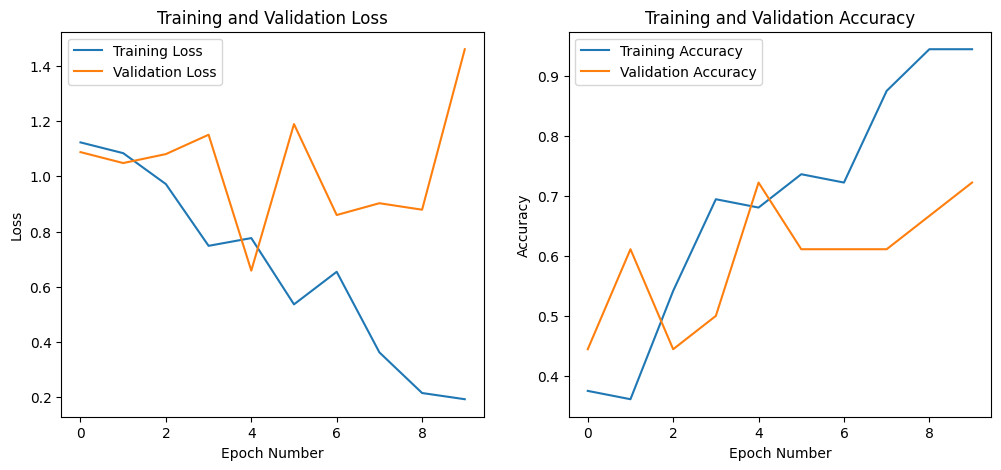

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plotting loss and accuracy curves for training and validation
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')   # @ plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history['train_accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

### **Model perfomance on test data**

In [ ]:
#To look at test data
for batch_mfcc, batch_labels in test_loader:
    print("Batch MFCC shape:", batch_mfcc.shape)
    print("Batch labels:", batch_labels)
    #break  # only show first batch

Batch MFCC shape: torch.Size([1, 1, 13, 200])
Batch labels: tensor([0])
Batch MFCC shape: torch.Size([1, 1, 13, 200])
Batch labels: tensor([0])
Batch MFCC shape: torch.Size([1, 1, 13, 200])
Batch labels: tensor([0])
Batch MFCC shape: torch.Size([1, 1, 13, 200])
Batch labels: tensor([0])
Batch MFCC shape: torch.Size([1, 1, 13, 200])
Batch labels: tensor([0])
Batch MFCC shape: torch.Size([1, 1, 13, 200])
Batch labels: tensor([0])
Batch MFCC shape: torch.Size([1, 1, 13, 200])
Batch labels: tensor([1])
Batch MFCC shape: torch.Size([1, 1, 13, 200])
Batch labels: tensor([1])
Batch MFCC shape: torch.Size([1, 1, 13, 200])
Batch labels: tensor([1])
Batch MFCC shape: torch.Size([1, 1, 13, 200])
Batch labels: tensor([1])
Batch MFCC shape: torch.Size([1, 1, 13, 200])
Batch labels: tensor([1])
Batch MFCC shape: torch.Size([1, 1, 13, 200])
Batch labels: tensor([1])
Batch MFCC shape: torch.Size([1, 1, 13, 200])
Batch labels: tensor([2])
Batch MFCC shape: torch.Size([1, 1, 13, 200])
Batch labels: tens

In [ ]:
# Load the best model weights
model.load_state_dict(torch.load('best_model.pth'))
model.eval()  # Set the model to evaluation mode

# Check if GPU is available and use it if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the appropriate device
model.to(device)

correct = 0
total = 0
with torch.no_grad():  # No gradient computation during inference
    for data in test_loader:
        inputs, labels = data  # Assuming data is a tuple (inputs, labels)
        # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)  # Get model outputs
        _, predicted = torch.max(outputs, 1)  # Get the predicted class

        # Print predicted and actual target values
        print("Predicted:", predicted.item(), "; Target:", labels.item())

        total += labels.size(0)  # Number of samples in the batch
        correct += (predicted == labels).sum().item()  # Count correct predictions


Predicted: 1 ; Target: 0
Predicted: 0 ; Target: 0
Predicted: 0 ; Target: 0
Predicted: 0 ; Target: 0
Predicted: 0 ; Target: 0
Predicted: 0 ; Target: 0
Predicted: 2 ; Target: 1
Predicted: 0 ; Target: 1
Predicted: 1 ; Target: 1
Predicted: 1 ; Target: 1
Predicted: 1 ; Target: 1
Predicted: 1 ; Target: 1
Predicted: 2 ; Target: 2
Predicted: 1 ; Target: 2
Predicted: 2 ; Target: 2
Predicted: 2 ; Target: 2
Predicted: 2 ; Target: 2
Predicted: 1 ; Target: 2


### **Overall accuracy**

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data  # Assuming data is a tuple (inputs, labels)
        # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)  # Get model outputs
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

# Calculate accuracy
accuracy = correct / total
print(f'Overall Test Accuracy: {accuracy * 100:.2f}%')

Accuracy for class: subhanallah is 83.3 %
Accuracy for class: allahuakbar is 66.7 %
Accuracy for class: alhamdulillah is 66.7 %
Overall Test Accuracy: 72.22%


### **Confusion Matrix**

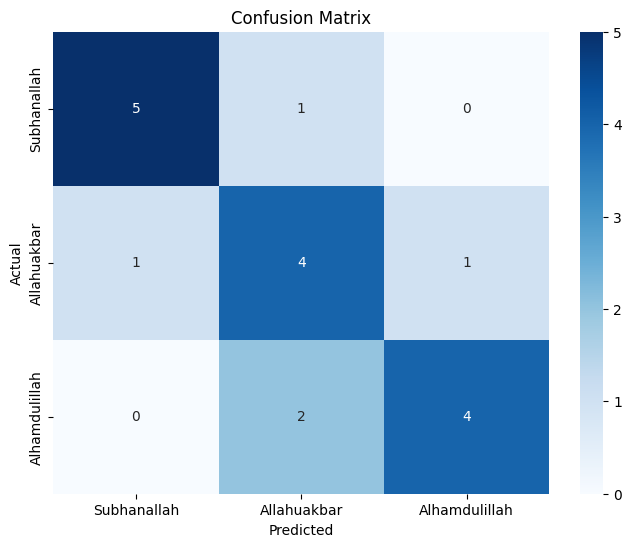

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Initialize lists to store the predictions and actual labels
all_predictions = []
all_labels = []

with torch.no_grad():  # Disable gradient computation
    for data in test_loader:
        inputs, labels = data  # Assuming data is a tuple (inputs, labels)

        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Get model predictions
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get predicted classes

        # Append predictions and actual labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Subhanallah', 'Allahuakbar', 'Alhamdulillah'], yticklabels=['Subhanallah', 'Allahuakbar', 'Alhamdulillah'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### **Discussion of results**

The model is trained for 10 epochs.

During the training process, the training loss decreases and the training accuracy increases, indicating effective learning on the training data.

The validation accuracy shows an increasing trend, suggesting that the model was generalizing to some extent, although the rising validation loss may indicate the beginning of overfitting.

The accuracy for the class *Subhanallah* is the highest at 83.3%, while the accuracy for the classes *Allahuakbar* and *Alhamdulillah* are both 66.7%.

The overall accuracy of the model in classifying the audio data into three categories is 72.22%.